In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
data = sm.datasets.macrodata.load_pandas().data
print(data.shape)
data.tail(5)

(203, 14)


,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
198,2008.0,3.0,13324.600,9267.7,1990.693,991.551,9838.3,216.889,1474.7,1.17,6.0,305.270,-3.16,4.33
199,2008.0,4.0,13141.920,9195.3,1857.661,1007.273,9920.4,212.174,1576.5,0.12,6.9,305.952,-8.79,8.91
200,2009.0,1.0,12925.410,9209.2,1558.494,996.287,9926.4,212.671,1592.8,0.22,8.1,306.547,0.94,-0.71
201,2009.0,2.0,12901.504,9189.0,1456.678,1023.528,10077.5,214.469,1653.6,0.18,9.2,307.226,3.37,-3.19
202,2009.0,3.0,12990.341,9256.0,1486.398,1044.088,10040.6,216.385,1673.9,0.12,9.6,308.013,3.56,-3.44


In [2]:
data1 = data[["realgdp", 'realdpi']]
data1.index = data["year"]
data1.head(5)

,realgdp,realdpi
year,,
1959.0,2710.349,1886.9
1959.0,2778.801,1919.7
1959.0,2775.488,1916.4
1959.0,2785.204,1931.3
1960.0,2847.699,1955.5


<Axes: xlabel='year'>

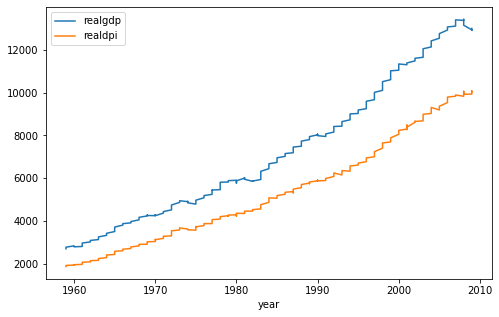

In [3]:
data1.plot(figsize = (8,5))

Before applying VAR, both the time series variable should be stationary. Both the series are not stationary since both the series do not show constant mean and variance over time. We can also perform a statistical test like the Augmented Dickey-Fuller test (ADF) to find stationarity of the series using the AIC criteria.

In [4]:
from statsmodels.tsa.stattools import adfuller
adfuller_test = adfuller(data1['realgdp'], autolag= "AIC")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

ADF test statistic: 1.7504627967647166
p-value: 0.9982455372335032


In [5]:
adfuller_test = adfuller(data1['realdpi'], autolag= "AIC")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

ADF test statistic: 2.9860253519546847
p-value: 1.0


In [6]:
# realgdp series becomes stationary after 1st differencing
data_d = data1.diff().dropna()
adfuller_test = adfuller(data_d['realgdp'], autolag= "AIC")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

ADF test statistic: -6.305695561658106
p-value: 3.327882187668224e-08


In [7]:
# realdpi series becomes stationary after 1st differencing
adfuller_test = adfuller(data_d['realdpi'], autolag= "AIC")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

ADF test statistic: -8.864893340673008
p-value: 1.4493606159108096e-14


In [8]:
# train-test split of the data and keep the last 10-days as test data
nobs = 10
train = data_d.iloc[:-nobs,:]
test = data_d.iloc[-nobs:,:]

In the process of VAR modeling, we opt to employ Information Criterion Akaike (AIC) as a model selection criterion to conduct optimal model identification. In simple terms, we select the order (p) of VAR based on the best AIC score. The AIC, in general, penalizes models for being too complex, though the complex models may perform slightly better on some other model selection criterion. Hence, we expect an inflection point in searching the order (p), meaning that, the AIC score should decrease with order (p) gets larger until a certain order and then the score starts increasing. For this, we perform grid-search to investigate the optimal order (p).

In [9]:
forecasting_model = VAR(train)
results_aic = []
for p in range(1,10):
  results = forecasting_model.fit(p)
  results_aic.append(results.aic)

C:\Users\mcnel\.julia\conda\3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


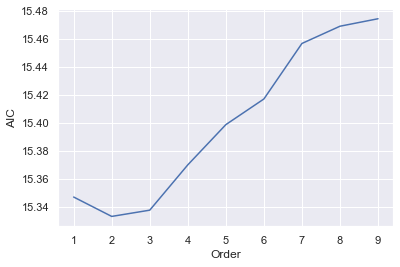

In [11]:
# From visual judgement, it seems should be 2
!pip install seaborn
import seaborn as sns
sns.set()
plt.plot(list(np.arange(1,10,1)), results_aic)
plt.xlabel("Order")
plt.ylabel("AIC")
plt.show()

In [12]:
# auto selection of best lag can be different than from visual judgement
forecasting_model.select_order(10)
results_auto = forecasting_model.fit(maxlags = 10, ic = "aic")
lag_order = results_auto.k_ar
lag_order

3

In [12]:
results = forecasting_model.fit(2)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 15, Aug, 2022
Time:                     16:25:13
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    15.5043
Nobs:                     190.000    HQIC:                   15.4026
Log likelihood:          -1985.87    FPE:                4.56270e+06
AIC:                      15.3334    Det(Omega_mle):     4.33171e+06
--------------------------------------------------------------------
Results for equation realgdp
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const             23.807343         6.111430            3.896           0.000
L1.realgdp         0.176227         0.078131            2.256           0.024
L1.realdpi         0.213713         0.085309            2.505         

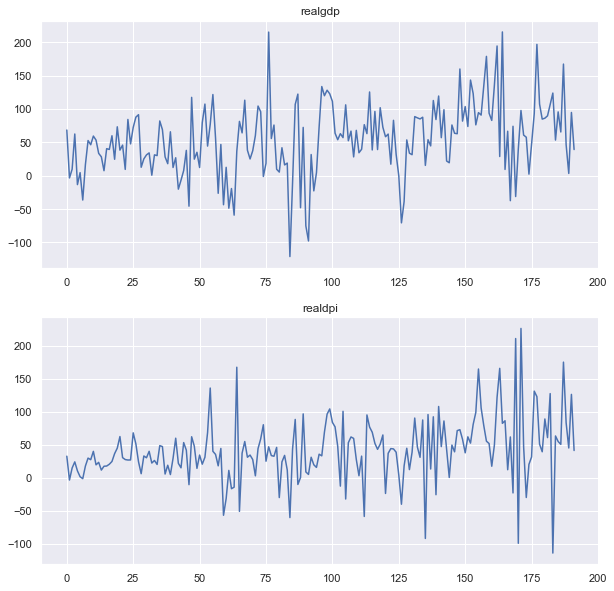

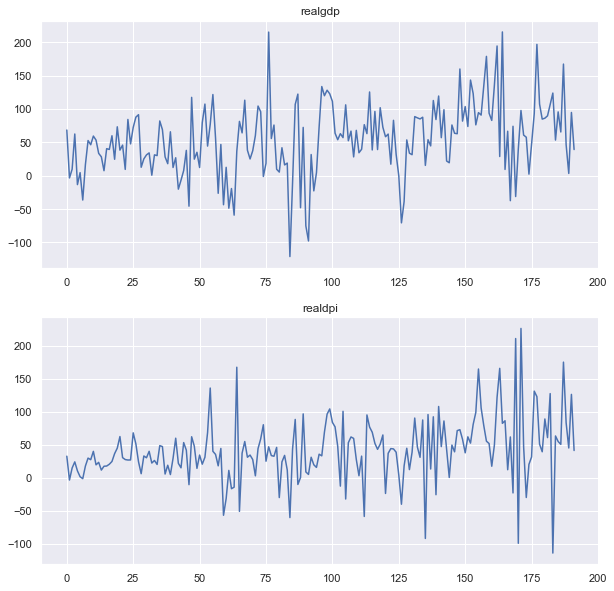

In [13]:
results.plot()

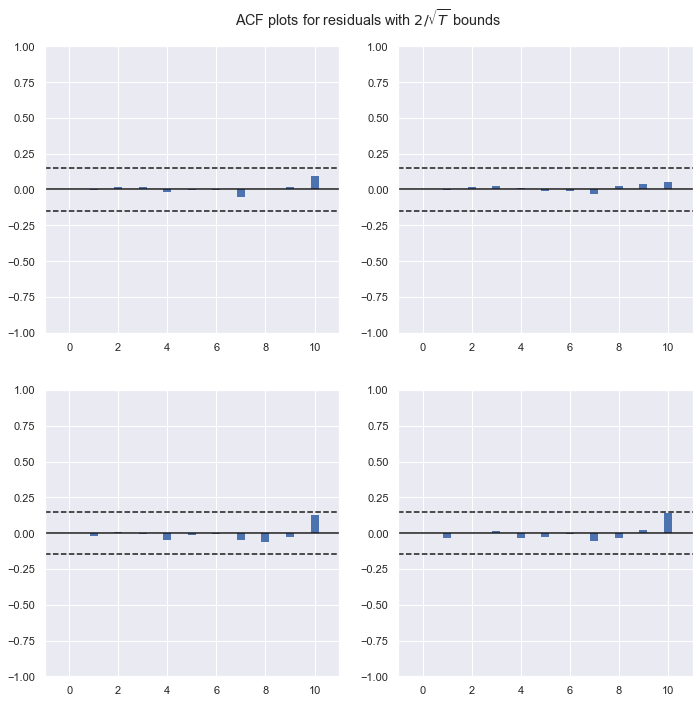

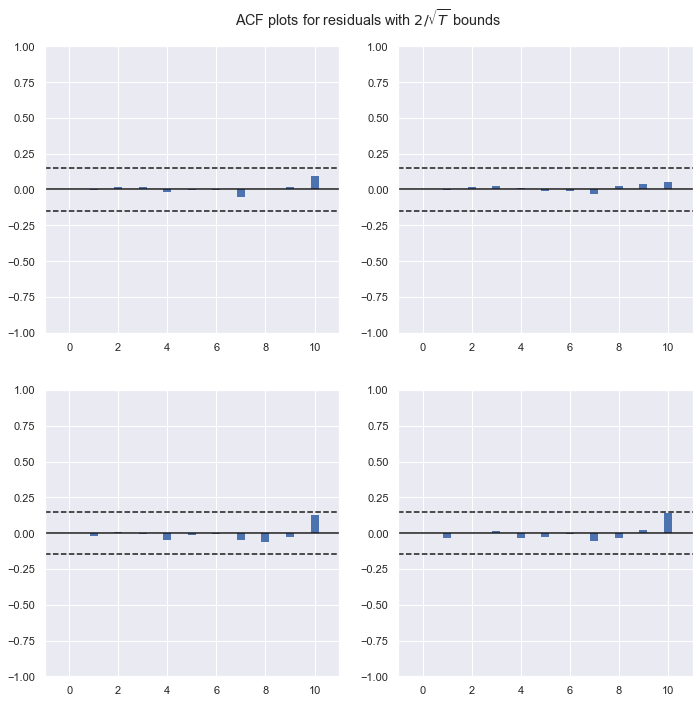

In [14]:
results.plot_acorr()

We use 2 as the optimal order in fitting the VAR model. Thus, we take the final 2 steps in the training data for forecasting the immediate next step (i.e., the first day of the test data). Now, after fitting the model, we forecast for the test data where the last 2 days of training data set as lagged values and steps set as 10 days as we want to forecast for the next 10 days.

In [15]:
train.values[-2:]

array([[ 94.763, 126.3  ],
       [ 39.222,  41.4  ]])

In [17]:
laaged_values = train.values[-9:]
forecast = pd.DataFrame(results.forecast(y= laaged_values, steps=10), index = test.index, columns= ['realgdp_1d', 'realdpi_1d'])
forecast

,realgdp_1d,realdpi_1d
year,,
2007.0,64.804206,8.758185
2007.0,74.208374,54.674068
2007.0,92.905453,41.564253
2008.0,75.856402,66.076513
2008.0,128.138055,92.982029
2008.0,102.101056,72.564253
2008.0,82.576829,53.617159
2009.0,82.840065,74.825924
2009.0,66.280862,36.916379


We have to note that the aforementioned forecasts are for the one differenced model. Hence, we must reverse the first differenced forecasts into the original forecast values.


In [18]:
forecast_1D = forecast.copy()
forecast["realgdp_forecasted"] = data1["realgdp"].iloc[-10-1] + forecast_1D['realgdp_1d'].cumsum()
forecast["realdpi_forecasted"] = data1["realdpi"].iloc[-10-1] + forecast_1D['realdpi_1d'].cumsum()
forecast 

,realgdp_1d,realdpi_1d,realgdp_forecasted,realdpi_forecasted
year,,,,
2007.0,64.804206,8.758185,13164.705206,9838.958185
2007.0,74.208374,54.674068,13238.913580,9893.632253
2007.0,92.905453,41.564253,13331.819033,9935.196506
2008.0,75.856402,66.076513,13407.675435,10001.273019
2008.0,128.138055,92.982029,13535.813490,10094.255047
2008.0,102.101056,72.564253,13637.914546,10166.819300
2008.0,82.576829,53.617159,13720.491375,10220.436460
2009.0,82.840065,74.825924,13803.331440,10295.262384
2009.0,66.280862,36.916379,13869.612302,10332.178763


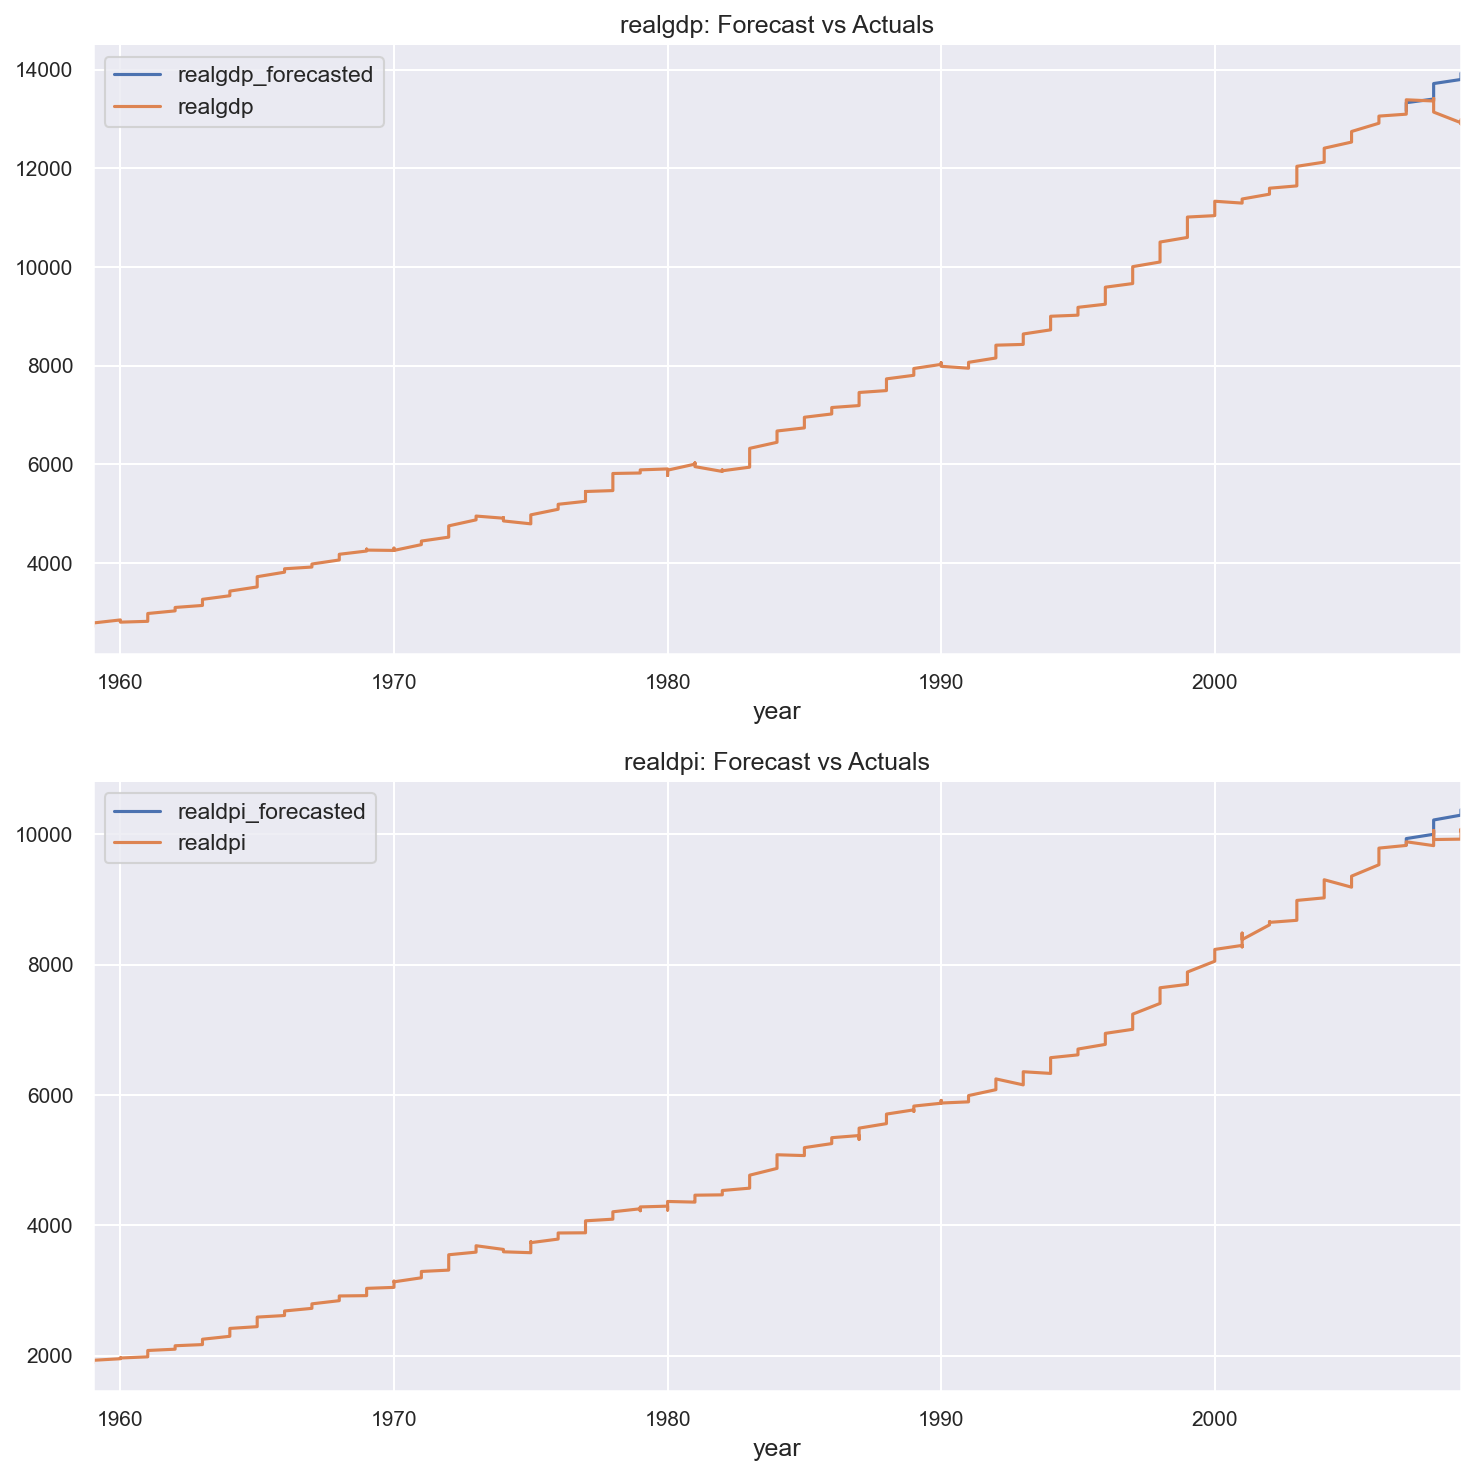

In [19]:
# plot forecast vs. actuals
fig, axes = plt.subplots(nrows=int(len(data1.columns)), ncols=1, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(data1.columns, axes.flatten())):
    forecast[col+'_forecasted'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    data1[col][-nobs:].plot(legend=True, ax=ax)
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=10)

plt.tight_layout()

Impulse responses are of interest in econometric studies: they are the estimated responses to a unit impulse in one of the variables. They are computed in practice using the MA(∞) representation of the VAR(p) process:
These can be visualized using the plot function, in either orthogonalized or non-orthogonalized form. Asymptotic standard errors are plotted by default at the 95% significance level, which can be modified by the user.

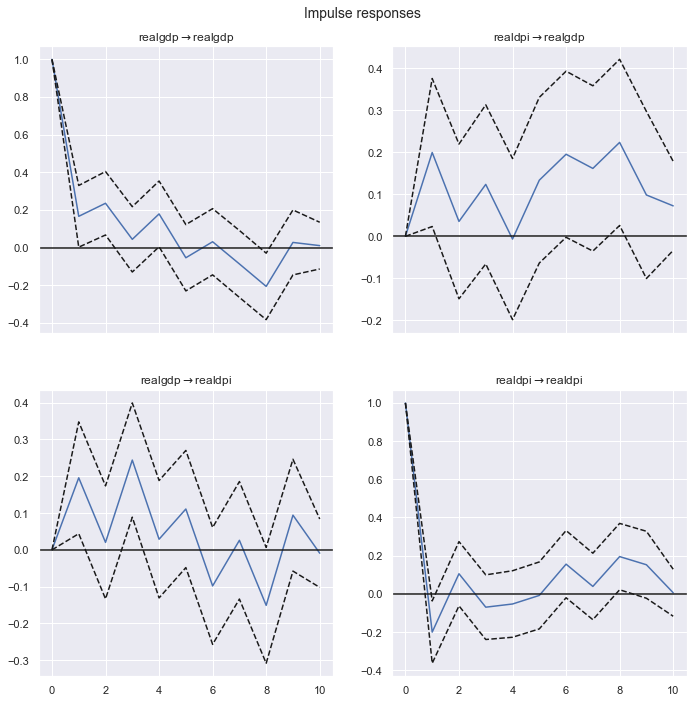

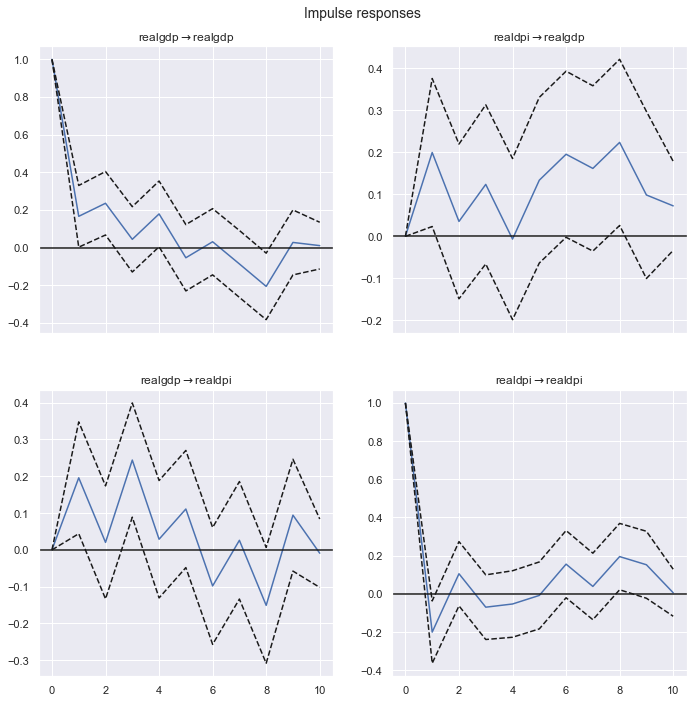

In [20]:
irf = results.irf(10)
irf.plot(orth=False)

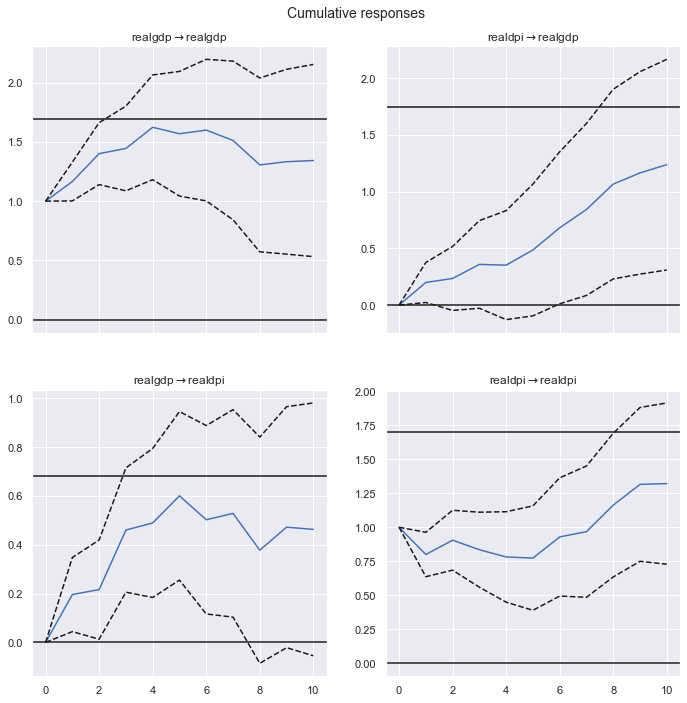

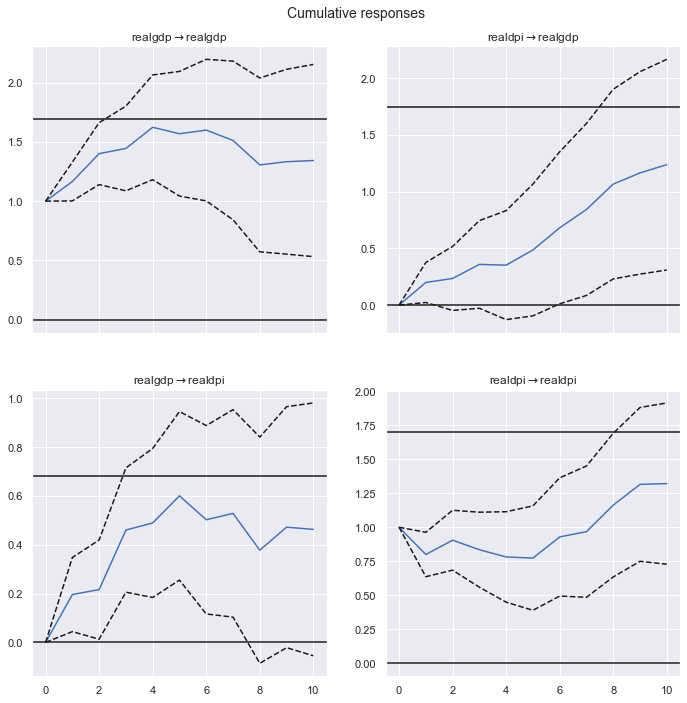

In [21]:
irf.plot_cum_effects(orth=False)

Forecast Error Variance Decomposition (FEVD)
Forecast errors of component j on k in an i-step ahead forecast can be decomposed using the orthogonalized impulse responses Θ𝑖:

In [22]:
fevd = results.fevd(5)
fevd.summary()

FEVD for realgdp
      realgdp   realdpi
0    1.000000  0.000000
1    0.972739  0.027261
2    0.973401  0.026599
3    0.964082  0.035918
4    0.964990  0.035010

FEVD for realdpi
      realgdp   realdpi
0    0.136340  0.863660
1    0.147296  0.852704
2    0.148934  0.851066
3    0.190948  0.809052
4    0.190630  0.809370




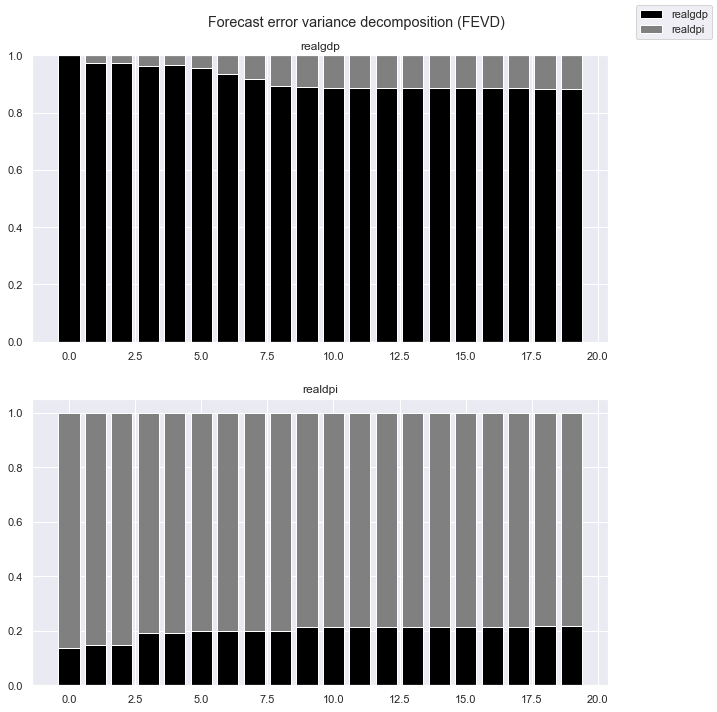

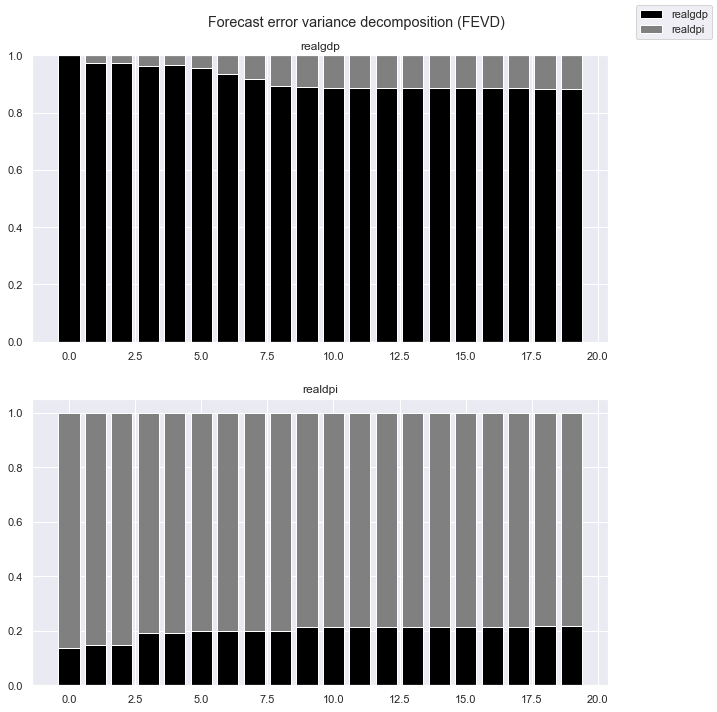

In [23]:
results.fevd(20).plot()

Granger causality
One is often interested in whether a variable or group of variables is “causal” for another variable, for some definition of “causal”. In the context of VAR models, one can say that a set of variables are Granger-causal within one of the VAR equations. We will not detail the mathematics or definition of Granger causality, but leave it to the reader. The VARResults object has the test_causality method for performing either a Wald (𝜒2) test or an F-test.

In [24]:
print(results.test_causality('realgdp', 'realdpi', kind='f'))
print(results.test_normality())

<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: realdpi does not Granger-cause realgdp: fail to reject at 5% significance level. Test statistic: 1.586, critical value: 1.908>, p-value: 0.118>
<statsmodels.tsa.vector_ar.hypothesis_test_results.NormalityTestResults object. H_0: data generated by normally-distributed process: reject at 5% significance level. Test statistic: 75.476, critical value: 9.488>, p-value: 0.000>


The following is Bayesian Based Vector Autoregression: The Bayesian approach offers a probabilistic approach to time series to reduce uncertainty and incorporate “prior” information. These models are referred to as Dynamic Linear Models or Structural Time Series (state space models). They work by fitting the structural changes in a time series dynamically — in other words, evolving and updating the model parameters over time with the addition of new information. In contrast, VAR estimates parameters for the series, which remain fixed, then uses Maximum Likelihood estimation for determining the time series predictions. Bayesian methods use MCMC (Monte Carlo Markov Chains) to generate estimates from distributions. It’s a k-step-ahead prediction starting from the beginning of the series and updating each parameter as you move through the series. Therefore, each step-ahead is actually a true “out-of-sample prediction”, and thus there error from the prediction reflects true out-of-sample estimates based on the posterior probabilities. For ARIMA to do this, you would need to specify a hold-out sample at the end of your series, then implement a for-loop that iterates of each data point in the hold-out sample, update the model, move to the next point, update the model.

In [26]:
from scipy import stats
!pip install pybats
import pybats
from pybats.loss_functions import MAPE, MAD, ZAPE
from pybats.analysis import analysis
from pybats.point_forecast import median, m_one_median
from pandas.tseries.holiday import USFederalHolidayCalendar
from pybats.plot import *

  Using cached asttokens-2.2.1-py2.py3-none-any.whl (26 kB)


Three problems could be for VAR models, 1. the data is not stationary, 2. there appears to be a possible seasonal effect, 3. the variance increases with time. for BVAR, these would be not a problem. So we can use data2, not datad here for BVAR model. These are in general belonging to a group of BSTS(Bayesian Structured Time Series).

<Axes: xlabel='year'>

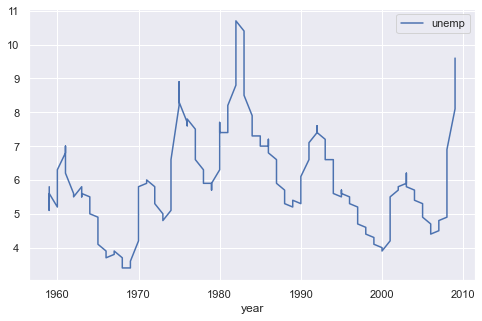

In [27]:
data2 = data[["year", "quarter", "realgdp", 'realdpi', 'realcons',	'realinv',	'realgovt',	'cpi',	'm1', 'tbilrate', 'unemp']]
data2.plot(x='year', y='unemp', figsize = (8,5))

In [28]:
data2.index = data["year"]
data2 = data2.drop("year", axis=1)
data2

,quarter,realgdp,realdpi,realcons,realinv,realgovt,cpi,m1,tbilrate,unemp
year,,,,,,,,,,
1959.0,1.0,2710.349,1886.9,1707.4,286.898,470.045,28.980,139.7,2.82,5.8
1959.0,2.0,2778.801,1919.7,1733.7,310.859,481.301,29.150,141.7,3.08,5.1
1959.0,3.0,2775.488,1916.4,1751.8,289.226,491.260,29.350,140.5,3.82,5.3
1959.0,4.0,2785.204,1931.3,1753.7,299.356,484.052,29.370,140.0,4.33,5.6
1960.0,1.0,2847.699,1955.5,1770.5,331.722,462.199,29.540,139.6,3.50,5.2
...,...,...,...,...,...,...,...,...,...,...
2008.0,3.0,13324.600,9838.3,9267.7,1990.693,991.551,216.889,1474.7,1.17,6.0
2008.0,4.0,13141.920,9920.4,9195.3,1857.661,1007.273,212.174,1576.5,0.12,6.9
2009.0,1.0,12925.410,9926.4,9209.2,1558.494,996.287,212.671,1592.8,0.22,8.1


In [29]:
future = {"year": [2009, 2010, 2010, 2010, 2010],
          "quarter": [4.0, 1.0, 2.0, 3.0, 4.0],
          "realgdp": [13080.0, 13100.0, 13120.0, 13170.0, 13200.0],
          "realdpi": [10080.0, 10100.0, 10120.0, 10170.0, 10200.0],
          "realcons": [9300.0, 9320.0, 9350.0, 9400.0, 9450.0],
          "realinv": [1400.0, 1380.0, 1350.0, 1320.0, 1300.0],
          "realgovt": [1100.0, 1120.0, 1140.0, 1150.0, 1200.0],
          "cpi": [215.0, 217.0, 216.0, 214.0, 220.0],
          "m1": [1700.0, 1710.0, 1730.0, 1800.0, 1820.0],
          "tbilrate": [0.12, 0.11, 0.10, 0.11, 0.09],
          }
df_future = pd.DataFrame(future) 
df_future.set_index('year', inplace=True)
df_future

,quarter,realgdp,realdpi,realcons,realinv,realgovt,cpi,m1,tbilrate
year,,,,,,,,,
2009,4.0,13080.0,10080.0,9300.0,1400.0,1100.0,215.0,1700.0,0.12
2010,1.0,13100.0,10100.0,9320.0,1380.0,1120.0,217.0,1710.0,0.11
2010,2.0,13120.0,10120.0,9350.0,1350.0,1140.0,216.0,1730.0,0.10
2010,3.0,13170.0,10170.0,9400.0,1320.0,1150.0,214.0,1800.0,0.11
2010,4.0,13200.0,10200.0,9450.0,1300.0,1200.0,220.0,1820.0,0.09


In [30]:
X_future = df_future.iloc[:, [7,8]].values
X_future

array([[1.70e+03, 1.20e-01],
       [1.71e+03, 1.10e-01],
       [1.73e+03, 1.00e-01],
       [1.80e+03, 1.10e-01],
       [1.82e+03, 9.00e-02]])

In [31]:
def order_qoy(seas_eff, quarter):
    out = np.zeros(4)
    out[int(quarter-1)] = seas_eff[0]
    return out

beginning forecasting
(6000, 100, 4) (100, 4)
    1-Q Ahead  2-Q Ahead  3-Q Ahead  4-Q Ahead
95        5.0        5.0        5.0        5.0
96        5.0        5.0        5.0        6.0
97        5.0        5.0        6.0        6.0
98        5.0        6.0        6.0        6.0
99        6.0        6.0        6.0        6.0
MAPE:  [6.43, 8.02, 9.69, 11.99]
MAD:  [0.36, 0.46, 0.57, 0.72]
ZAPE:  [6.43, 8.02, 9.69, 11.99]


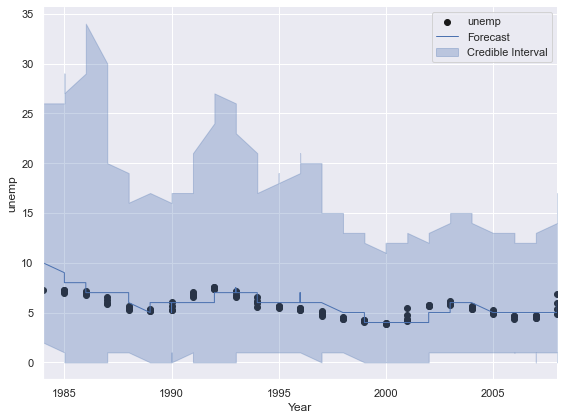

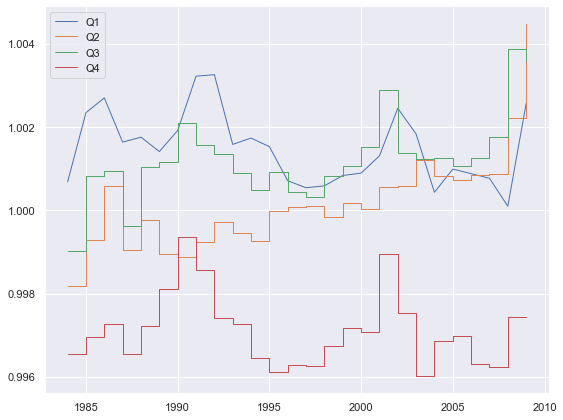

In [32]:
def bayes_forecast(iv,dv,tv,tq,k,credible_interval=95):
    '''
    This function runs the Pybats algorithm by taking two sequential time series: 
    an independent variable matrix and a dependent variable. 
    '''
    # first check if the iv = None, indicating this would be a univariate series
    if iv is None:
        x = None
    else:
        x = iv.values    
    y = dv.values
    z = tv.values
    q = tq.values    
    forecast_start = 100                                         
    forecast_end = len(y)-k
    #The analysis function Define a model prior, sequentially update the model (forward filter) and forecast
    #k steps ahead return the final model, forecast samples, and potentially the stored model coefficients   
    mod, samples, model_coef = analysis(Y=y, X=x, family='poisson',
                                        forecast_start=forecast_start,      
                                        forecast_end=forecast_end,         
                                        k=k,                                
                                        ntrend=2,
                                        nsamps=6000,
                                        seasPeriods=[4], #yearly trend on quarterly observations
                                        seasHarmComponents=[[1,2]],
                                        #holidays=USFederalHolidayCalendar.rules,
                                        prior_length=15, 
                                        dates=tv,                    
                                        deltrend=0.99,  #each time step we discount the old coefficient information by adding                    
                                        delregn=0.98,   #100% - 98% = 2% more uncertainty (variance).This enables the coefficient                   
                                        delVar=0.98,    #to learn more quickly from new observations in the time series.
                                        delSeas=0.99,
                                        delhol=1,
                                        rho=.9, #Random effect extension, which increases the forecast variance
                                        ret = ['model', 'forecast', 'model_coef']
                                        )                            
    forecast = median(samples)
    #forecast = m_one_median(samples)
    print(samples.shape,forecast.shape)
    forecast_df = pd.DataFrame(forecast)
    forecast_df.columns = [(str(i+1)+'-Q Ahead') for i in range(forecast.shape[1])]
    print(forecast_df.round(2).tail())
    # set confidence interval for in-sample forecast    
    alpha = (100-credible_interval)/2
    upper=np.percentile(samples, [100-alpha], axis=0).reshape(-1)
    lower=np.percentile(samples, [alpha], axis=0).reshape(-1)
    #median of sample is used for our point forecast - the median is the optimal forecast for 
    #minimizing the MAD(mean absolute deviation), just as the mean is optimal for minimizing 
    #the Mean Square Error (MSE). Zero-Adjusted Absolute Percent Error (ZAPE). This is equivalent
    #to the Mean Absolute Percent Error (MAPE), but is still defined even when the y are 0. 
    #On quarters when y are 0, then the ZAPE loss is equal to the forecast. Interpreting this as 
    #a percent error metric, we're off by a significant margin - but not bad for noisy y! The median
    #is not the optimal forecast to minimize ZAPE, but it's a simple and easy point forecast to obtain
    horizons = list(range(1, k+1))
    print("MAPE: ", list(map(lambda k: MAPE(y[forecast_start+(k-1):forecast_end+(k-1)+1],
                                            forecast[:,k-1]).round(2), horizons)))
    print("MAD: ", list(map(lambda k: MAD(y[forecast_start+(k-1):forecast_end+(k-1)+1],
                                          forecast[:,k-1]).round(2), horizons)))
    print("ZAPE: ", list(map(lambda k: ZAPE(y[forecast_start+(k-1):forecast_end+(k-1)+1],
                                            forecast[:,k-1]).round(2), horizons)))    
    # Plot the k-step ahead point forecast plus the passed in credible interval
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))   
    ax = plot_data_forecast(fig, ax, y[forecast_start+k-1:forecast_end+k], forecast[:,k-1],
                            samples[:,:,k-1], dates=z[forecast_start+k-1:forecast_end+k])
    ax = ax_style(ax, ylabel=dv.name, xlabel='Year', xlim=[z[forecast_start], z[forecast_end]],
                  legend=[dv.name, 'Forecast', 'Credible Interval'])
    #Taking the posterior coefficents and only looking at the 4 seasonal coefficients, using the 'mod.iseas'
    #property to get the indices for the seasonal components. Transform these harmonic seasonal components
    #into interpretable coefficients for the 4 quarters of the year. align these 4 components with the
    #qaurters of the year, and plot the posterior mean of the coefficients over time.
    harm_post_mean = model_coef['m'][:, mod.iseas[0]]
    qoy_post_mean = mod.L[0] @ harm_post_mean.T    
    qoy_post_mean_plot = pd.DataFrame([order_qoy(seas_eff, quarter) for seas_eff, quarter 
                                       in zip(qoy_post_mean.T, q[:forecast_end+k])])
    qoy_post_mean_plot = qoy_post_mean_plot.replace(to_replace=0, method='ffill')
    quarters = ['Q1', 'Q2', 'Q3', 'Q4']
    start_quarter = 10    # Only starting to plot after model has learned the quarter-of-year effect
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax = plot_coef(fig, ax, np.exp(qoy_post_mean_plot)[forecast_start+k-1:forecast_end+k].values,
                    dates=z[forecast_start+k-1:forecast_end+k], legend=quarters)  
    #Generate the Bayesian Future Forecast
    return mod, forecast, samples, y, model_coef
# 4 quarter ahead frecasting
mv_mod, mv_for, mv_samp, mv_y, mv_coef = bayes_forecast(data2.iloc[:, [7, 8]], data2.unemp, data2.index, data2.quarter, 4, 68)

In [33]:
print("# of (trend, regression, and seasonal) components: ", (mv_mod.ntrend, mv_mod.nregn, mv_mod.nseas))
print(mv_mod.get_coef())
print("posterior mean of the trend coefficients: \n", mv_mod.a[mv_mod.itrend].round(3))
print("posterior variance of the trend coefficients: \n", mv_mod.R.diagonal()[mv_mod.itrend].round(3))
print("posterior mean of the regression coefficients: \n", mv_mod.a[mv_mod.iregn].round(3))
print("posterior variance of the regression coefficients: \n", mv_mod.R.diagonal()[mv_mod.iregn].round(3))
#A good rule of thumb to get a pseudo-confidence interval is to add ± 2*sd(coefficient) for 95% CI
mean, sd = mv_mod.get_coef('regn').values[1] # get state vector variables for the second predictor
print("CI for 95% of second regression coefficient: ", (np.round(mean+2*sd, 3), np.round(mean-2*sd, 3)))

# of (trend, regression, and seasonal) components:  (2, 2, 4)
             Mean  Standard Deviation
Intercept    0.03                3.08
Local Slope -0.01                0.03
Regn 1       0.00                0.00
Regn 2      -0.04                0.06
Seas 1      -0.01                0.05
Seas 2      -0.00                0.05
Seas 3      -0.00                0.04
Seas 4       0.00                1.00
posterior mean of the trend coefficients: 
 [[ 0.028]
 [-0.009]]
posterior variance of the trend coefficients: 
 [9.462e+00 1.000e-03]
posterior mean of the regression coefficients: 
 [[ 0.001]
 [-0.044]]
posterior variance of the regression coefficients: 
 [0.    0.003]
CI for 95% of second regression coefficient:  (0.08, -0.16)


The Python function above can also run the equivalent model without the covariate(s) — so a standard univariate time series. We’re doing this to determine if including the independent variable(s)(in this case GDP) in the model is having the intended effect of reducing the overall residual error in the model. In other words, does including the GDP variable improve our understanding of the data; is it worth including them in the model?

beginning forecasting
(6000, 100, 4) (100, 4)
    1-Q Ahead  2-Q Ahead  3-Q Ahead  4-Q Ahead
95        5.0        5.0        5.0        5.0
96        5.0        5.0        5.0        5.0
97        5.0        5.0        5.0        5.0
98        5.0        5.0        5.0        5.0
99        5.0        5.0        5.0        5.0
MAPE:  [19.99, 20.58, 21.79, 22.88]
MAD:  [1.11, 1.15, 1.22, 1.29]
ZAPE:  [19.99, 20.58, 21.79, 22.88]


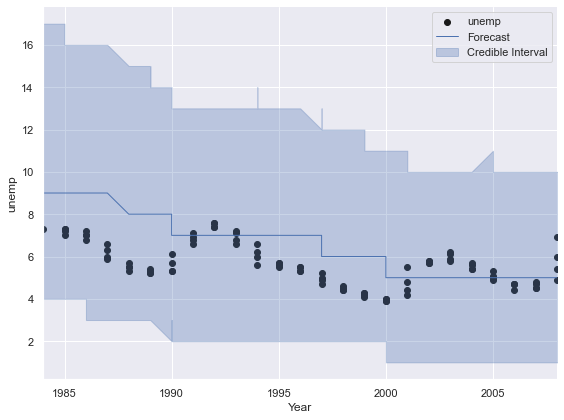

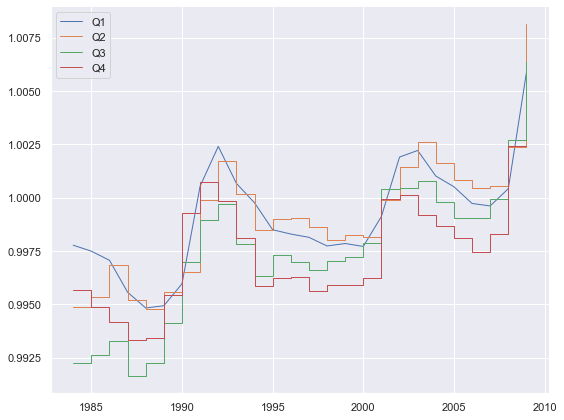

In [34]:
# Calculate Bayesian estimate for the univariate model
uv_mod, uv_for, uv_samp, uv_y, uv_coef = bayes_forecast(None, data2.unemp, data2.index, data2.quarter, 4, 68)

The above is a one-step-ahead prediction starting from the beginning of the series and updating each parameter as you move through the series. Therefore, each step-ahead is actually a true “out-of-sample prediction”, and thus the error from the prediction reflects true out-of-sample estimates based on the posterior probabilities. The plot below compares the cumulative error between the two models (univariate and multivariate). It shows that the covariates begin to explain more of the variability in the time series model as time progresses — which is what we would expect as the model learns and adjusts the parameters based on previous values.

In [35]:
#Update the DGLM state vector mean and covariance after observing 'y', with covariates 'X'
mv_mod.update(y = 11, X = X_future[0])
mv_mod.get_coef()

,Mean,Standard Deviation
Intercept,-0.15,3.05
Local Slope,-0.01,0.03
Regn 1,0.00,0.00
Regn 2,-0.04,0.06
Seas 1,-0.00,0.05
Seas 2,0.00,0.05
Seas 3,0.00,0.03
Seas 4,0.00,1.00


In [36]:
# marginal forecast 1 step ahead
forecast_samples = mv_mod.forecast_marginal(k = 1, X = X_future[0], nsamps=1000)
print(forecast_samples[:10])
forecasted = median(forecast_samples)
forecasted

[19 18  7 13 15  6 13  6 16 10]


10.0

In [37]:
# marginal forecast 5 step ahead
forecast_samples = mv_mod.forecast_marginal(k = 5, X = X_future[4], nsamps=1000)
print(forecast_samples[:10])
forecasted = median(forecast_samples)
forecasted

[ 8  2  7 11 12  8 15 24 15 14]


12.0

In [38]:
# path forecast
forecast_samples = mv_mod.forecast_path(k = 5, X = X_future, nsamps=1000)
print(forecast_samples[:10])
forecasted1 = median(forecast_samples)
forecasted1

[[20 11 13 14 11]
 [12  9  7 12  4]
 [17 12 11 10 11]
 [ 3  3  6  4  6]
 [17  8  9  9 18]
 [ 7  5 14 13 10]
 [10  8  9  3  4]
 [ 3 11 11  9 11]
 [19 14 15 12  8]
 [13  8  9 16  9]]


array([10., 10., 11., 12., 12.])

In [39]:
m_samp = forecast_samples.mean(axis=0)
m_marg = np.array([mv_mod.forecast_marginal(k=1, X=X_future[0], mean_only=True),
                   mv_mod.forecast_marginal(k=2, X=X_future[1], mean_only=True),
                   mv_mod.forecast_marginal(k=3, X=X_future[2], mean_only=True),
                   mv_mod.forecast_marginal(k=4, X=X_future[3], mean_only=True),
                   mv_mod.forecast_marginal(k=5, X=X_future[4], mean_only=True),]).reshape(-1)
print("path: ", m_samp)
print("marginal: ", m_marg)
assert (np.equal(np.around(m_samp - m_marg), np.zeros(5)).all())

path:  [10.89  10.667 11.29  12.463 12.676]
marginal:  [10.81856388 10.91645533 11.15434903 12.3440252  12.76232573]


forecast unknown predictor values using DLM time series forecast for `m1`, and `tbilrate` 

beginning forecasting
(6000, 100, 4) (100, 4)
    1-Q Ahead  2-Q Ahead  3-Q Ahead  4-Q Ahead
95    1432.80    1440.37    1450.23    1455.05
96    1439.93    1447.07    1456.74    1464.30
97    1443.32    1451.98    1462.44    1471.83
98    1451.81    1461.32    1469.18    1476.24
99    1462.03    1469.23    1478.67    1485.93
MAPE:  [8.09, 8.39, 8.74, 9.08]
MAD:  [75.94, 79.61, 84.11, 88.58]
ZAPE:  [8.09, 8.39, 8.74, 9.08]


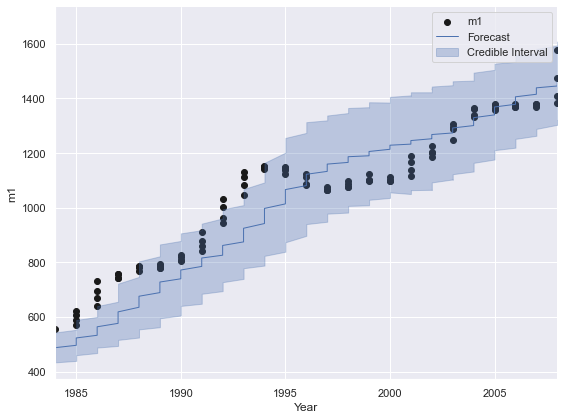

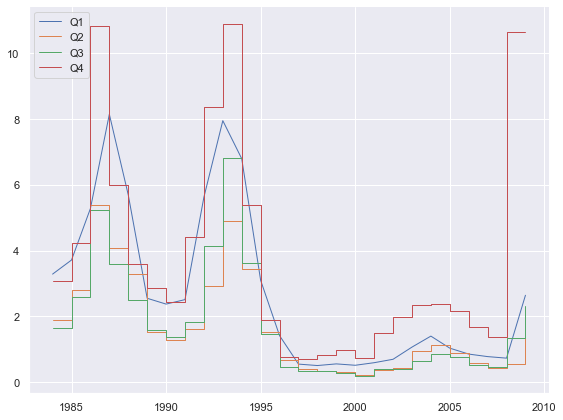

In [40]:
def predictors_forecast(iv, dv, tv, tq, k, credible_interval=95):
    '''
    This function runs the Pybats algorithm by taking one sequential time series: 
    an index variable and a dependent variable. 
    '''
    # first check if the iv = None, indicating this would be a univariate series
    if iv is None:
        x = None
    else:
        x = iv.values      
    y = dv.values
    z = tv.values
    q = tq.values 
    forecast_start = 100                                         
    forecast_end = len(y)-k
    #The analysis function Define a model prior, sequentially update the model (forward filter) and forecast
    #k steps ahead return the final model, forecast samples, and potentially the stored model coefficients   
    mod, samples, model_coef = analysis(Y=y, X=x, family='normal',
                                        forecast_start=forecast_start,      
                                        forecast_end=forecast_end,         
                                        k=k,                                
                                        ntrend=2,
                                        nsamps=6000,
                                        seasPeriods=[4], #yearly trend on quarterly observations
                                        seasHarmComponents=[[1,2]],
                                        #holidays=USFederalHolidayCalendar.rules,
                                        prior_length=15, 
                                        dates=tv,
                                        deltrend=0.99,  #each time step we discount the old coefficient information by adding                    
                                        delregn=0.98,   #100% - 98% = 2% more uncertainty (variance).This enables the coefficient                   
                                        delVar=0.98,    #to learn more quickly from new observations in the time series.
                                        delSeas=0.99,
                                        delhol=1,
                                        rho=.9, #Random effect extension, which increases the forecast variance
                                        ret = ['model', 'forecast', 'model_coef']
                                        )                            
    forecast = median(samples)
    #forecast = m_one_median(samples)
    print(samples.shape,forecast.shape)
    forecast_df = pd.DataFrame(forecast)
    forecast_df.columns = [(str(i+1)+'-Q Ahead') for i in range(forecast.shape[1])]
    print(forecast_df.round(2).tail())
    # set confidence interval for in-sample forecast    
    alpha = (100-credible_interval)/2
    upper=np.percentile(samples, [100-alpha], axis=0).reshape(-1)
    lower=np.percentile(samples, [alpha], axis=0).reshape(-1)    
    horizons = list(range(1, k+1))
    print("MAPE: ", list(map(lambda k: MAPE(y[forecast_start+(k-1):forecast_end+(k-1)+1],
                                            forecast[:,k-1]).round(2), horizons)))
    print("MAD: ", list(map(lambda k: MAD(y[forecast_start+(k-1):forecast_end+(k-1)+1],
                                          forecast[:,k-1]).round(2), horizons)))
    print("ZAPE: ", list(map(lambda k: ZAPE(y[forecast_start+(k-1):forecast_end+(k-1)+1],
                                            forecast[:,k-1]).round(2), horizons)))    
    # Plot the k-step ahead point forecast plus the credible interval
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))   
    ax = plot_data_forecast(fig, ax, y[forecast_start+k-1:forecast_end+k], forecast[:,k-1],
                            samples[:,:,k-1], dates=z[forecast_start+k-1:forecast_end+k])
    ax = ax_style(ax, ylabel=dv.name, xlabel='Year', xlim=[z[forecast_start], z[forecast_end]],
                  legend=[dv.name, 'Forecast', 'Credible Interval'])
    #Taking the posterior coefficents and only looking at the 4 seasonal coefficients, using the 'mod.iseas'
    #property to get the indices for the seasonal components. Transform these harmonic seasonal components
    #into interpretable coefficients for the 4 quarters of the year. align these 4 components with the
    #qaurters of the year, and plot the posterior mean of the coefficients over time.
    harm_post_mean = model_coef['m'][:, mod.iseas[0]]
    qoy_post_mean = mod.L[0] @ harm_post_mean.T    
    qoy_post_mean_plot = pd.DataFrame([order_qoy(seas_eff, quarter) for seas_eff, quarter 
                                       in zip(qoy_post_mean.T, q[:forecast_end+k])])
    qoy_post_mean_plot = qoy_post_mean_plot.replace(to_replace=0, method='ffill')
    quarters = ['Q1', 'Q2', 'Q3', 'Q4']
    start_quarter = 10    # Only starting to plot after model has learned the quarter-of-year effect
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax = plot_coef(fig, ax, np.exp(qoy_post_mean_plot)[forecast_start+k-1:forecast_end+k].values,
                    dates=z[forecast_start+k-1:forecast_end+k], legend=quarters)  
    #Generate the Bayesian Future Forecast
    return mod, forecast, samples, y, model_coef
# 4 quarter ahead forecasting
p_mod, p_for, p_samp, p_y, p_coef = predictors_forecast(None, data2.m1, data2.index, data2.quarter, 4, 95)         

In [41]:
# this predictor forecasted lower than natural trend rolling average
forecast_predictors = p_mod.forecast_path(k = 5, X = None, nsamps=1000)
print(forecast_predictors[:10])
m1_forecasted = median(forecast_predictors)
m1_forecasted

[[1513.4772342  1427.8558148  1568.89906033 1623.72988437 1521.1549984 ]
 [1335.01383278 1425.55291075 1614.62123723 1265.32574247 1561.95124626]
 [1625.41040022 1562.50094148 1494.48283774 1539.51292656 1633.23539573]
 [1672.2249694  1632.83664003 1550.99061238 1438.46655415 1489.64347624]
 [1529.01682627 1515.334887   1551.8446574  1522.95031429 1581.07351926]
 [1538.02008058 1533.41483834 1518.66197433 1488.24184744 1534.43036562]
 [1573.93791318 1436.47599695 1607.7577595  1504.20959597 1525.97011804]
 [1394.26374416 1473.44020639 1570.67942134 1550.50471998 1503.44634478]
 [1678.71159962 1593.20009867 1617.80918224 1397.67865844 1673.01774332]
 [1648.0409227  1451.73373333 1527.80928211 1437.1083419  1593.58816099]]


array([1521.79672769, 1530.68957848, 1537.31901147, 1541.70378539,
       1560.19283232])

beginning forecasting
(6000, 100, 4) (100, 4)
    1-Q Ahead  2-Q Ahead  3-Q Ahead  4-Q Ahead
95       2.92       2.88       2.78       2.93
96       2.94       2.82       2.89       2.79
97       2.79       2.87       2.78       2.75
98       2.77       2.67       2.65       2.55
99       2.66       2.56       2.51       2.49
MAPE:  [81.51, 94.46, 110.75, 133.57]
MAD:  [1.89, 1.98, 2.07, 2.15]
ZAPE:  [81.51, 94.46, 110.75, 133.57]


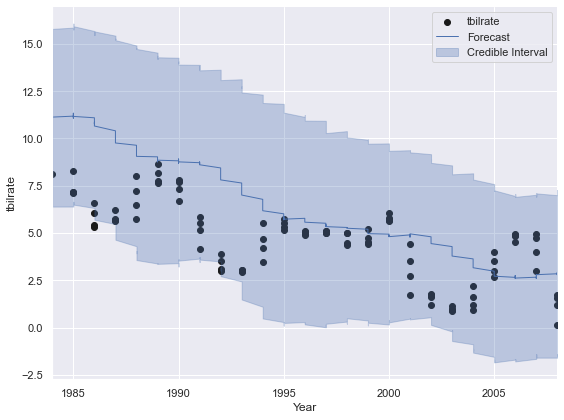

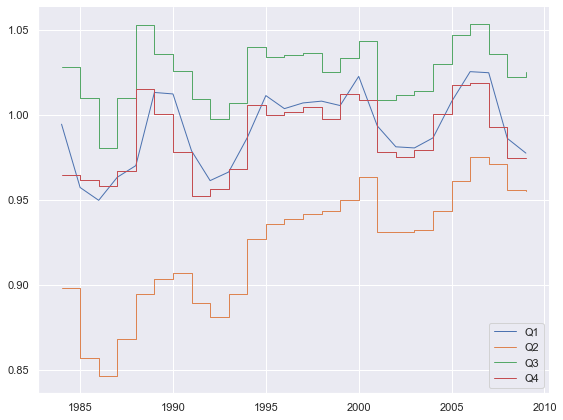

In [42]:
p2_mod, p2_for, p2_samp, p2_y, p2_coef = predictors_forecast(None, data2.tbilrate, data2.index, data2.quarter, 4, 95)

In [43]:
# forecasted this predictor a little too high
forecast_predictors = p2_mod.forecast_path(k = 5, X = None, nsamps=1000)
print(forecast_predictors[:10])
tbilrate_forecasted = median(forecast_predictors)
tbilrate_forecasted

[[-0.14644966  1.97551609  2.78293437  0.93928498  4.00337321]
 [ 0.34341232  0.59194065  4.37011962  0.92686502  1.17489097]
 [ 2.45617928  4.97686772  2.78546983  3.12346324  0.49684489]
 [-0.88887692 -0.33953217  0.21369318 -0.10871605  3.88901471]
 [ 3.14907715 -1.03289077 -3.60973583 -5.58609701  1.76029558]
 [-0.55539373  3.71581775  0.63621237  3.38041226 -0.57434985]
 [ 9.76379751  3.65470415  1.10475439  3.14027199 -0.6874251 ]
 [ 2.18572553 -0.41258595  0.95538446  2.32799838  1.94899417]
 [ 2.64924543  0.08634324 -0.64586909  1.78252848 -0.81288898]
 [-1.78021541  5.65741733  3.72282125  1.19748776  1.10930011]]


array([2.07760952, 1.99337885, 1.8044599 , 2.00847197, 1.84615014])

In [44]:
# generate new future X by zipping two arrays of m1 and tbilrate values
X_future_1 = np.vstack((m1_forecasted, tbilrate_forecasted)).T
X_future_1

array([[1521.79672769,    2.07760952],
       [1530.68957848,    1.99337885],
       [1537.31901147,    1.8044599 ],
       [1541.70378539,    2.00847197],
       [1560.19283232,    1.84615014]])

In [45]:
# path forecast again and see the dlm forecasted predictors generate lower target unemployment than before
forecast_samples = mv_mod.forecast_path(k = 5, X = X_future_1, nsamps=1000)
print(forecast_samples[:10])
forecasted2 = median(forecast_samples)
forecasted2

[[ 9 12 10 13 19]
 [ 3  3  5  3  8]
 [ 6 10 14 20 14]
 [ 9  2  3  3  5]
 [11  6  6  8  3]
 [ 6 15 16 16 18]
 [15 12  9 18 16]
 [ 2  1  4  1  0]
 [ 5  6  5 11  5]
 [ 8 12 10 10 16]]


array([7., 7., 7., 7., 8.])

As we can clearly see the forecast turned opposite direction because the predictors do not behave the same. VAR model for m1 and tbilrate might be good for estimation of predictors using lagged VAR 

In [46]:
data3 = data2[["m1", "tbilrate"]]
data3a = data2[["quarter", "m1", "tbilrate"]]
data3.tail(5)

,m1,tbilrate
year,,
2008.0,1474.7,1.17
2008.0,1576.5,0.12
2009.0,1592.8,0.22
2009.0,1653.6,0.18
2009.0,1673.9,0.12


<Axes: xlabel='year'>

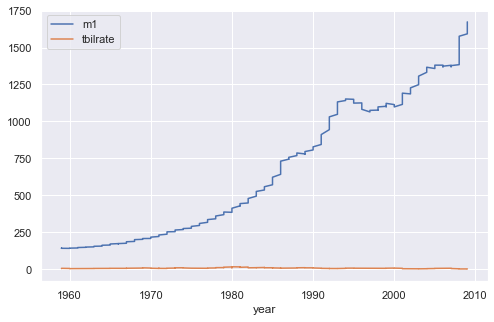

In [47]:
data3.plot(figsize = (8,5))

In [48]:
adfuller_test = adfuller(data3['m1'], autolag= "AIC")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

ADF test statistic: 2.0530797438644224
p-value: 0.9987380758531885


In [49]:
adfuller_test = adfuller(data3['tbilrate'], autolag= "AIC")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

ADF test statistic: -2.038579111768228
p-value: 0.26991776442261606


In [50]:
# m1 series becomes stationary after 1st differencing
data_d3 = data3.diff().dropna()
adfuller_test = adfuller(data_d3['m1'], autolag= "AIC")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

ADF test statistic: -3.4823186961564034
p-value: 0.008452969705352725


In [51]:
# tbilrate series becomes stationary after 1st differencing
adfuller_test = adfuller(data_d3['tbilrate'], autolag= "AIC")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

ADF test statistic: -6.034760202617051
p-value: 1.390582569334804e-07


C:\Users\mcnel\.julia\conda\3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


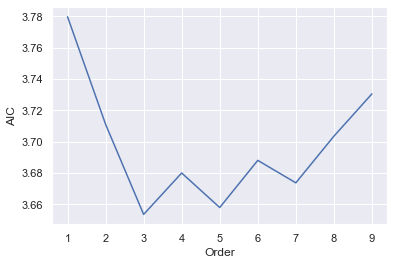

In [52]:
# train-test split of the data_d3 and keep the last 10-days as test data
nobs = 10
train = data_d3.iloc[:-nobs,:]
test = data_d3.iloc[-nobs:,:]
forecasting_model3 = VAR(train)
results_aic = []
for p in range(1,10):
    results = forecasting_model3.fit(p)
    results_aic.append(results.aic)
# From visual judgement, it seems should be 3
import seaborn as sns
sns.set()
plt.plot(list(np.arange(1,10,1)), results_aic)
plt.xlabel("Order")
plt.ylabel("AIC")
plt.show()

In [53]:
# auto selection of best lag can be different than from visual judgement
forecasting_model3.select_order(10)
results_auto = forecasting_model3.fit(maxlags = 10, ic = "aic")
lag_order = results_auto.k_ar
lag_order

7

In [54]:
results = forecasting_model3.fit(3)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 17, Mar, 2023
Time:                     09:05:46
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    3.89376
Nobs:                     189.000    HQIC:                   3.75092
Log likelihood:          -867.627    FPE:                    38.6174
AIC:                      3.65364    Det(Omega_mle):         35.9083
--------------------------------------------------------------------
Results for equation m1
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               2.086761         0.685179            3.046           0.002
L1.m1               0.358020         0.075525            4.740           0.000
L1.tbilrate        -2.203622         0.647241           -3.405         

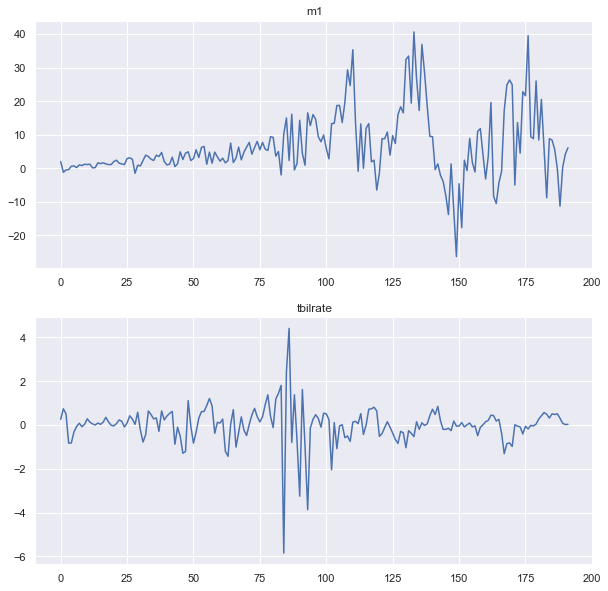

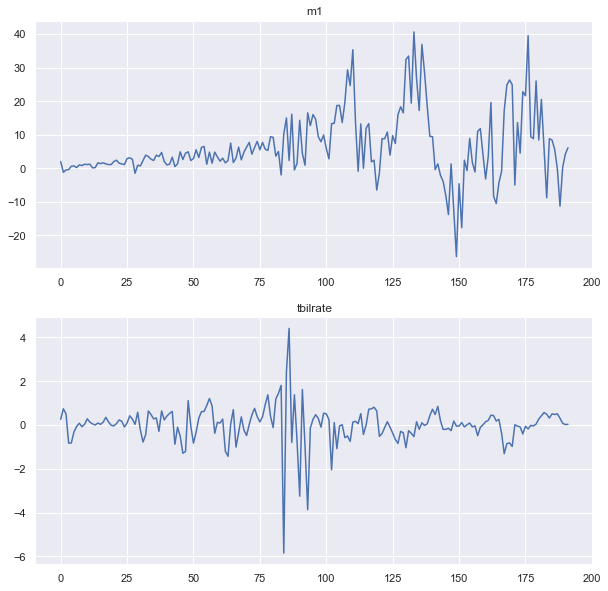

In [56]:
results.plot()

In [57]:
lagged_values = train.values[-3:]
forecast = pd.DataFrame(results.forecast(y= lagged_values, steps=10), index = test.index, columns= ['m1_1d', 'tbilrate_1d'])
forecast

,m1_1d,tbilrate_1d
year,,
2007.0,4.965134,-0.011966
2007.0,5.649015,-0.029787
2007.0,5.925888,0.012254
2008.0,6.003815,-0.004154
2008.0,6.235829,-0.014871
2008.0,6.325422,0.001556
2008.0,6.408147,0.000357
2009.0,6.504015,-0.003860
2009.0,6.548774,0.000930


In [58]:
forecast_1D = forecast.copy()
forecast["m1_forecasted"] = data3["m1"].iloc[-10-1] + forecast_1D['m1_1d'].cumsum()
forecast["tbilrate_forecasted"] = data3["tbilrate"].iloc[-10-1] + forecast_1D['tbilrate_1d'].cumsum()
forecast

,m1_1d,tbilrate_1d,m1_forecasted,tbilrate_forecasted
year,,,,
2007.0,4.965134,-0.011966,1384.665134,4.938034
2007.0,5.649015,-0.029787,1390.314149,4.908248
2007.0,5.925888,0.012254,1396.240037,4.920502
2008.0,6.003815,-0.004154,1402.243852,4.916348
2008.0,6.235829,-0.014871,1408.479680,4.901477
2008.0,6.325422,0.001556,1414.805102,4.903033
2008.0,6.408147,0.000357,1421.213249,4.903390
2009.0,6.504015,-0.003860,1427.717265,4.899530
2009.0,6.548774,0.000930,1434.266039,4.900459


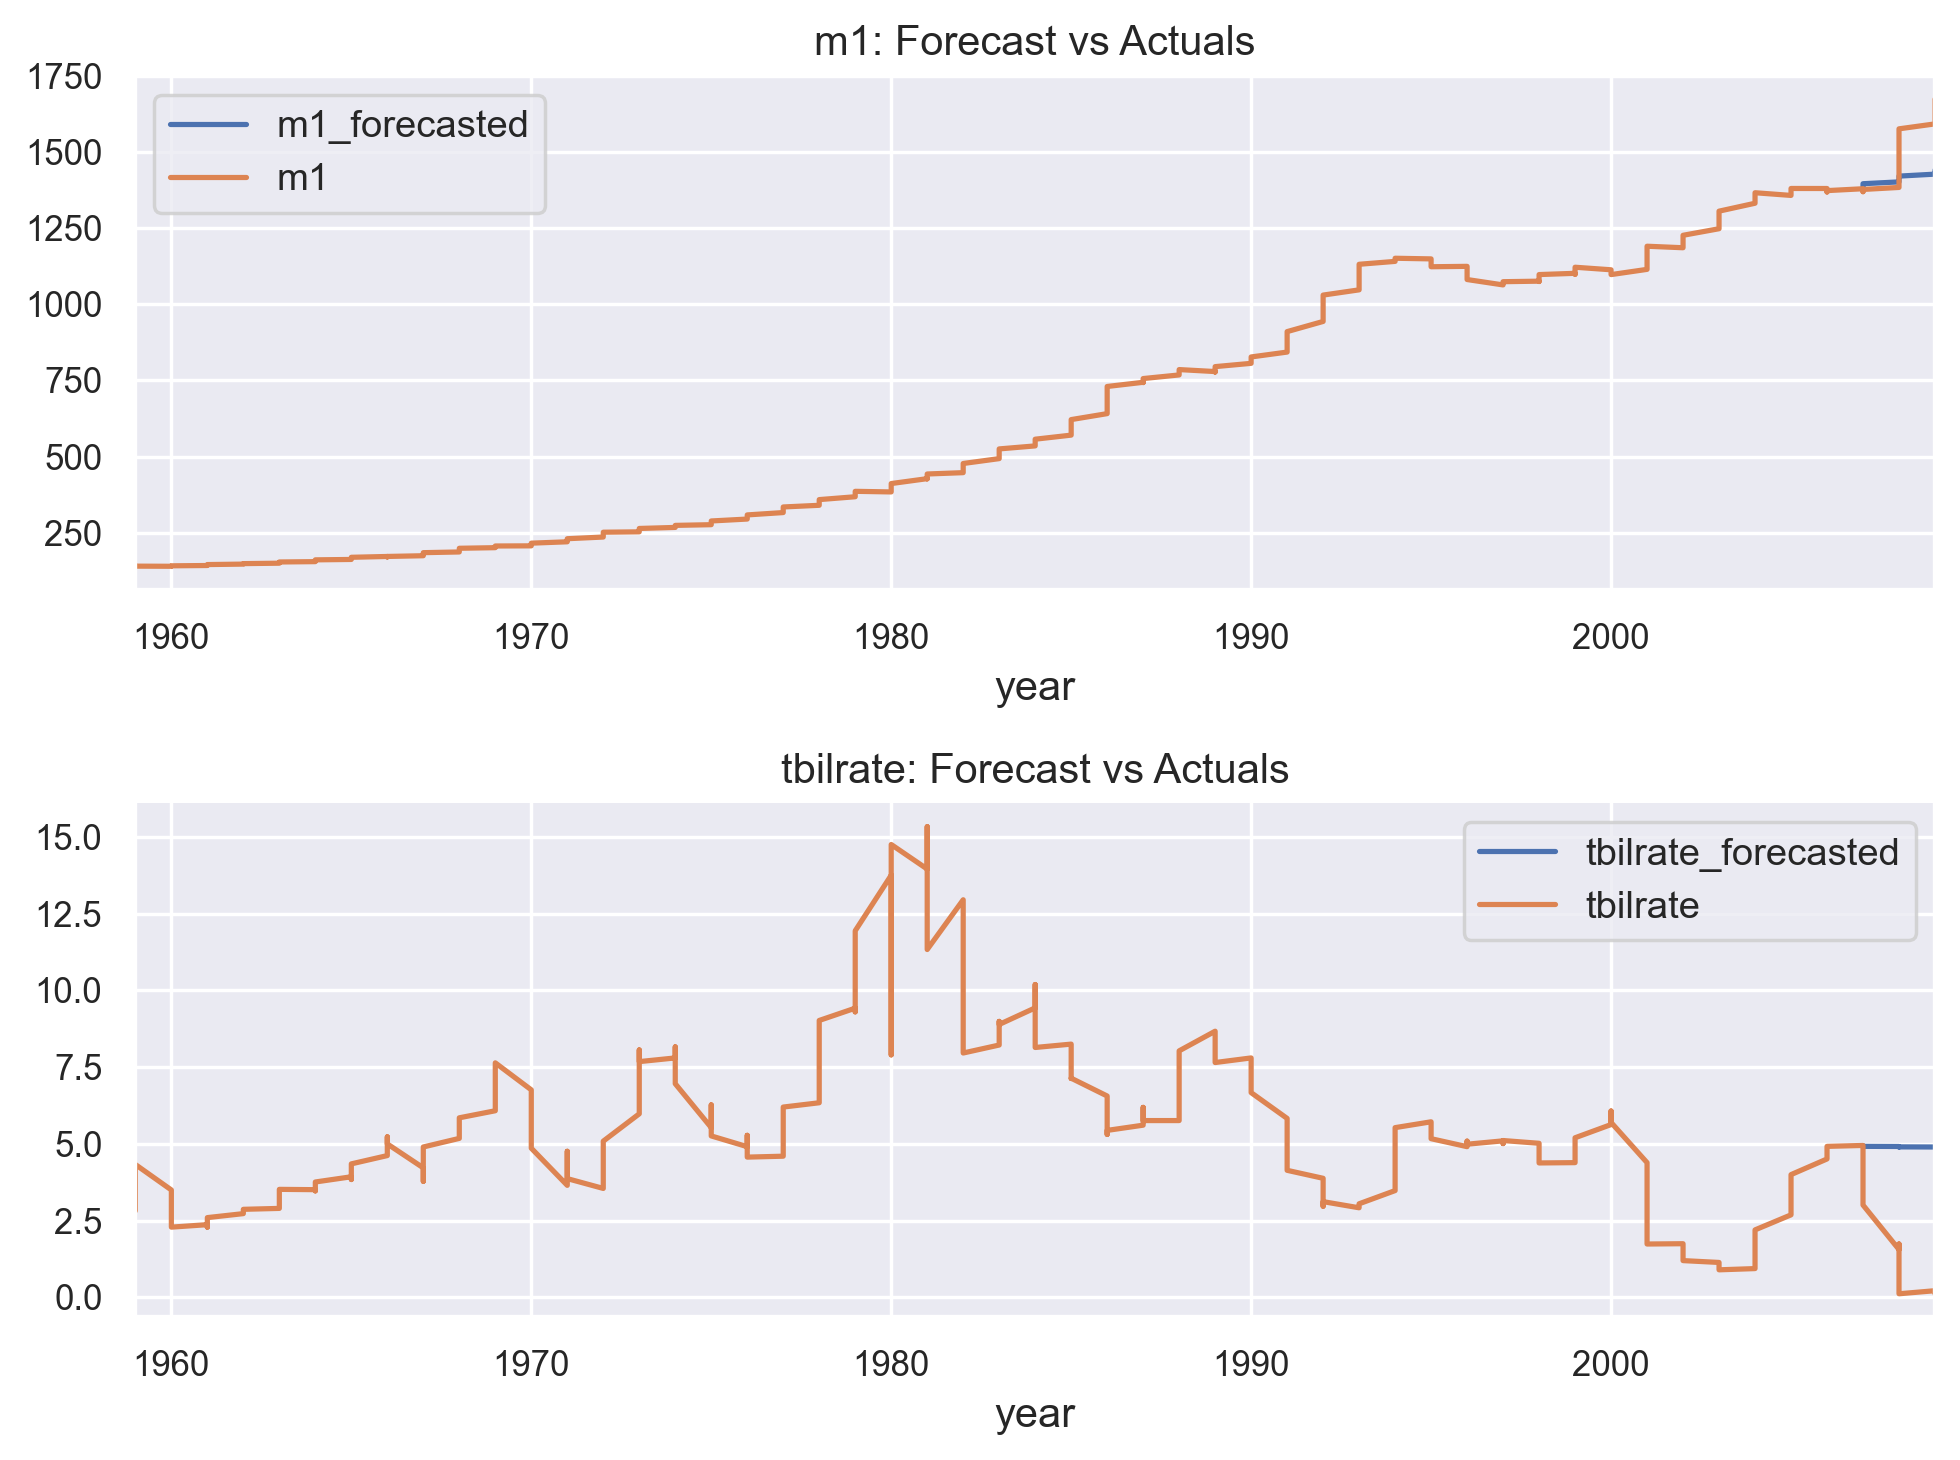

In [59]:
# plot forecast vs. actuals
fig, axes = plt.subplots(nrows=int(len(data3.columns)), ncols=1, dpi=250, figsize=(8,6))
for i, (col,ax) in enumerate(zip(data3.columns, axes.flatten())):
    forecast[col+'_forecasted'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    data3[col][-nobs:].plot(legend=True, ax=ax)
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=10)
plt.tight_layout()

As we can see VAR does not give much better forecast for predictors either because it simply extends out from lag values

C:\Users\mcnel\.julia\conda\3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


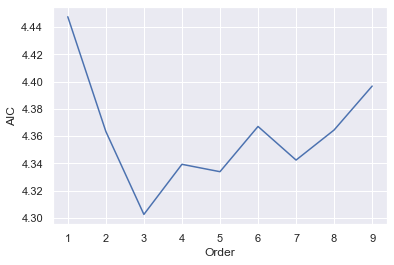

In [60]:
#future_forecast now
forecasting_model4 = VAR(data_d3)
results_aic = []
for p in range(1,10):
    results = forecasting_model4.fit(p)
    results_aic.append(results.aic)
# From visual judgement, it seems should be 3
import seaborn as sns
sns.set()
plt.plot(list(np.arange(1,10,1)), results_aic)
plt.xlabel("Order")
plt.ylabel("AIC")
plt.show()

In [61]:
results = forecasting_model4.fit(3)
lagged_values = data_d3.values[-3:]
forecast = pd.DataFrame(results.forecast(y= lagged_values, steps=5), index = [2009.0, 2010.0, 2010.0, 2010.0, 2010.0], columns= ['m1_1d', 'tbilrate_1d'])
forecast

,m1_1d,tbilrate_1d
2009.0,27.486798,-0.198863
2010.0,19.279682,0.362616
2010.0,16.944230,0.062083
2010.0,14.774397,-0.017409
2010.0,11.966409,0.125712


In [62]:
forecast_1D = forecast.copy()
forecast["m1_forecasted"] = data3["m1"].iloc[-1] + forecast_1D['m1_1d'].cumsum()
forecast["tbilrate_forecasted"] = data3["tbilrate"].iloc[-1] + forecast_1D['tbilrate_1d'].cumsum()
forecast

,m1_1d,tbilrate_1d,m1_forecasted,tbilrate_forecasted
2009.0,27.486798,-0.198863,1701.386798,-0.078863
2010.0,19.279682,0.362616,1720.666480,0.283753
2010.0,16.944230,0.062083,1737.610710,0.345836
2010.0,14.774397,-0.017409,1752.385106,0.328427
2010.0,11.966409,0.125712,1764.351515,0.454139


In [63]:
# generate new future X by taking m1 and tbilrate values 2-d array
X_future_2 = forecast[["m1_forecasted", "tbilrate_forecasted"]].values
X_future_2

array([[ 1.70138680e+03, -7.88628398e-02],
       [ 1.72066648e+03,  2.83753205e-01],
       [ 1.73761071e+03,  3.45835969e-01],
       [ 1.75238511e+03,  3.28426547e-01],
       [ 1.76435151e+03,  4.54138530e-01]])

In [64]:
# path forecast again and see the VAR forecasted predictors and we got forecatsed unemployment inbetween the artificial and DLM ones
forecast_samples = mv_mod.forecast_path(k = 5, X = X_future_2, nsamps=1000)
print(forecast_samples[:10])
forecasted3 = median(forecast_samples)
forecasted3

[[11  5 15  9 10]
 [13 14  9 13  8]
 [ 5  9  6 10  8]
 [ 4  7  6 10  7]
 [13  8  9 12 13]
 [ 2  8 13  8 12]
 [10 13 11  7 10]
 [ 4  6  5  4  1]
 [10  7  6 13 13]
 [ 6  3 10  6  5]]


array([10., 11., 11., 11., 11.])

beginning forecasting
(6000, 98, 3) (98, 3)
    1-Q Ahead  2-Q Ahead  3-Q Ahead
93       4.16       3.56       2.94
94       3.42       2.84       1.80
95       2.71       1.75       1.88
96       1.60       1.77       1.33
97       1.69       1.23       0.61
MAPE:  [47.82, 58.09, 65.76]
MAD:  [0.98, 1.07, 1.13]
ZAPE:  [47.82, 58.09, 65.76]


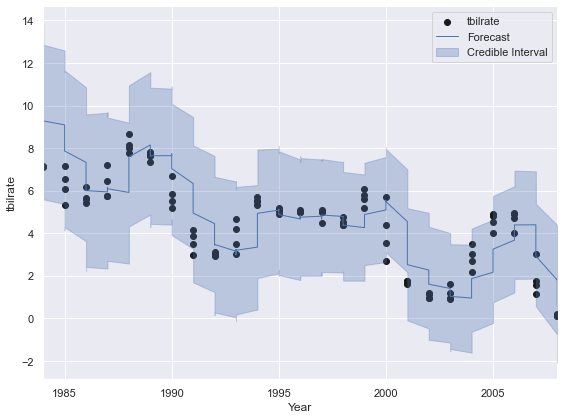

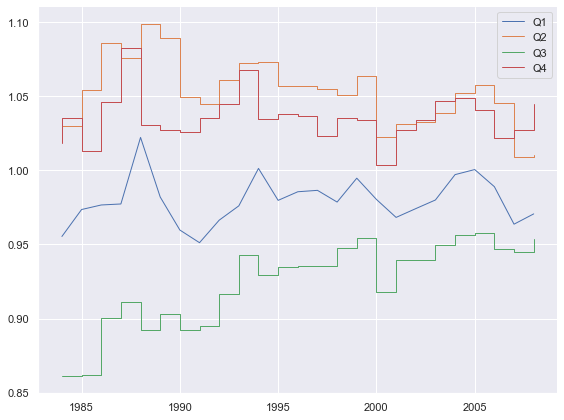

In [65]:
# Explore DLM for Lagged forecast of predictors, consider lap = 3 from the VAR experience
p3_mod, p3_for, p3_samp, p3_y, p3_coef = predictors_forecast(data3a.iloc[:-3].tbilrate, data3a.iloc[3:].tbilrate, data3a[3:].index, data3a[3:].quarter, 3, 95)

beginning forecasting
(6000, 98, 3) (98, 3)
    1-Q Ahead  2-Q Ahead  3-Q Ahead
93    1372.58    1380.84    1381.84
94    1392.66    1393.42    1400.16
95    1410.48    1417.42    1437.98
96    1481.02    1502.84    1554.35
97    1597.91    1652.47    1737.21
MAPE:  [1.13, 1.9, 2.52]
MAD:  [12.16, 20.42, 27.56]
ZAPE:  [1.13, 1.9, 2.52]


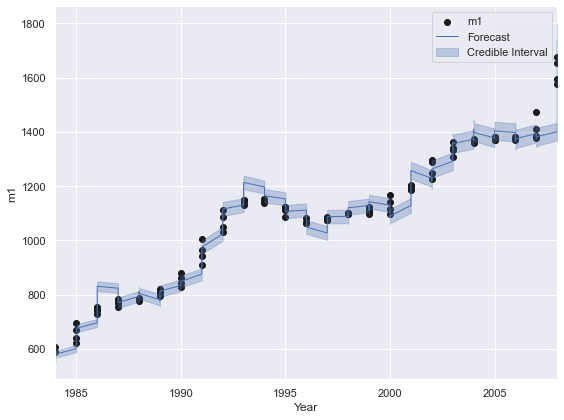

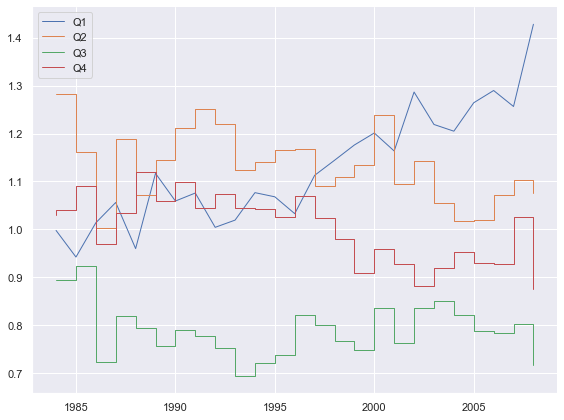

In [66]:
p4_mod, p4_for, p4_samp, p4_y, p4_coef = predictors_forecast(data3a.iloc[:-3].m1, data3a.iloc[3:].m1, data3a[3:].index, data3a[3:].quarter, 3, 95)

The above lagged DLM forecast for predictors looks good, future forecasts are used for unemployment forecast

In [67]:
m1_data=data3a.m1.values[-3:]
m1_future = np.reshape(m1_data, (-1, 1))

In [68]:
forecast_predictors = p4_mod.forecast_path(k = 3, X =m1_future, nsamps=1000)
print(forecast_predictors[:10])
m1_forecasted = median(forecast_predictors)
m1_forecasted

[[1697.59956105 1736.95968378 1755.30135528]
 [1713.55300642 1766.93579872 1784.97709611]
 [1701.65291499 1746.55251444 1765.61400335]
 [1661.13917348 1713.31275284 1731.85798119]
 [1655.24945276 1695.45069635 1709.31389167]
 [1684.3143965  1720.96328643 1738.05367745]
 [1701.0300038  1740.81419029 1757.75512883]
 [1723.64027498 1759.54984886 1776.60302718]
 [1661.62760578 1700.89336734 1714.79484808]
 [1741.28451034 1786.16247066 1798.18302241]]


array([1689.06134056, 1734.44209095, 1751.01722647])

In [69]:
tbilrate_data=data3a.tbilrate.values[-3:]
tbilrate_future = np.reshape(tbilrate_data, (-1, 1))
forecast_predictors = p3_mod.forecast_path(k = 3, X =tbilrate_future, nsamps=1000)
print(forecast_predictors[:10])
tbilrate_forecasted = median(forecast_predictors)
tbilrate_forecasted

[[ 2.16151263 -1.34963083  0.32387035]
 [-1.68070184 -0.22661177 -1.55758048]
 [-0.94969135 -0.98566341 -1.01428529]
 [ 2.49041253  1.38639371 -2.03082576]
 [-0.53654752  0.88466566  1.78518867]
 [-1.4476049   1.64321568 -1.46301161]
 [ 0.67426025  0.21923886 -0.72842654]
 [-0.44195568  0.03291426 -2.47334236]
 [-0.87234154 -0.62045739  1.29051635]
 [ 1.3841679   1.33537698  1.98296966]]


array([0.447518  , 0.3378886 , 0.24650197])

In [70]:
# generate new future X by taking m1 and tbilrate values 2-d array
X_future_3 = np.vstack((m1_forecasted, tbilrate_forecasted)).T
X_future_3

array([[1.68906134e+03, 4.47518000e-01],
       [1.73444209e+03, 3.37888597e-01],
       [1.75101723e+03, 2.46501966e-01]])

In [71]:
# path forecast again and see the lag DLM forecasted predictors and we got similar forecatsed unemployment as VAR forecasted predictors
forecast_samples = mv_mod.forecast_path(k = 3, X = X_future_3, nsamps=1000)
print(forecast_samples[:10])
forecasted4 = median(forecast_samples)
forecasted4

[[ 6  7  5]
 [12 14 17]
 [19 17 13]
 [ 7  3  6]
 [12 13 15]
 [ 9  7 15]
 [25 21 15]
 [12 16  8]
 [15 10 15]
 [ 8 12  4]]


array([10., 10., 11.])